# Objective of this notebook is to load your ungeocoded interferogram, remove the model, and add the amplitude back to the residual, and save as isce file

In [2]:
# load in dependecies 
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, tan, radians
from osgeo import osr, gdal
from okada_wrapper import dc3dwrapper
import utm

# new depedencies ise image
import isce
import isceobj
from stdproc.model.enu2los.ENU2LOS import ENU2LOS
import os

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce


# Extract both the phase and amplitude from the original interferogram

In [3]:
# extract the phase and amplitude seperately from the original interferogram (filt_topophase.flat)

# extract the phase
!imageMath.py -e'arg(a)' --a=/scratch/alor_2015_dsc_III/interferogram/filt_topophase.flat -t f -o phase.flat

#extract the amplitude
!imageMath.py -e'abs(a)' --a=/scratch/alor_2015_dsc_III/interferogram/filt_topophase.flat -t f -o amplitude.flat

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
args:  Namespace(debug=False, dtype='f', equation='arg(a)', hh=None, noxml=False, out='phase.flat', scheme='BSQ')
files:  ['--a=/scratch/alor_2015_dsc_III/interferogram/filt_topophase.flat']
/home/gareth/pkgs/isce2/applications/imageMath.py:418: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdoc

In [4]:
# load in all the directories

ifgpath="/scratch/alor_2015_dsc_III/"                     # directory with your interferogram
phint = '/home/karlee/earthquakes/alor_2015_JupNot/dsc_half_fringe_digitized/okapy/phase.flat' # the phase
ampint= '/home/karlee/earthquakes/alor_2015_JupNot/dsc_half_fringe_digitized/okapy/amplitude.flat' # the amplitude 
water_mask='/home/karlee/earthquakes/alor_2015_JupNot/dsc_half_fringe_digitized/ungeo3/watermk_ungeo.int' # watermask 


# directory to the ionosphere that was extrcted from the previous notebook
unw_iono='/scratch/alor_2015_dsc_III/ionosphere/dispersive.bil.unwCor.filt' # the ionosphere

# prelimary model created in the coseismic model notbeook
ungeo_model='/home/karlee/earthquakes/alor_2015_JupNot/dsc_half_fringe_digitized/ungeo2/model_ungeo.int' # the model

# saving the outfiles
out_isce = 'final_model.flat'



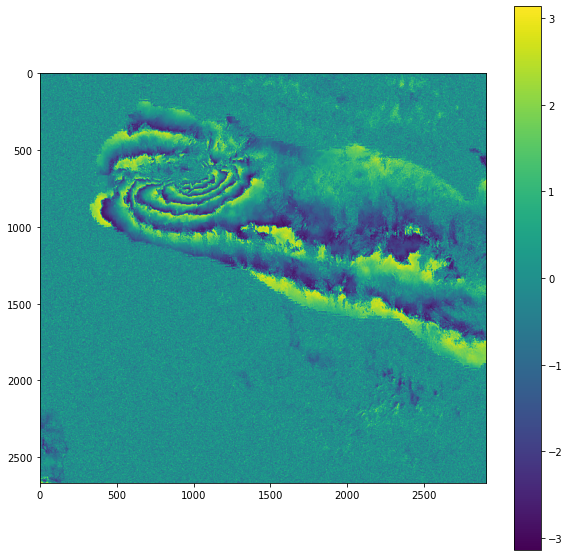

In [5]:
# load the ungeo phase from the interferogram
ifgfile=gdal.Open(phint,gdal.GA_ReadOnly)  
rb = ifgfile.GetRasterBand(1)                         # phase info is in band 2
iphase = rb.ReadAsArray()                                # read it in as a number array

#load in the amplitude for later 
ifgfile=gdal.Open(ampint,gdal.GA_ReadOnly)  
rb = ifgfile.GetRasterBand(1)                         # phase info is in band 2
iamp = rb.ReadAsArray()                                # read it in as a number array


# lets plot the ungeocoded interferogram in the wrapped phase 
fig, ax = plt.subplots(figsize=(10,10))        # new figure called "ax1"
im = ax.imshow(iphase,origin='upper')             # plot incidence with origin at upper left (isce default)
fig.colorbar(im)                               # plot a color bar!
plt.show()

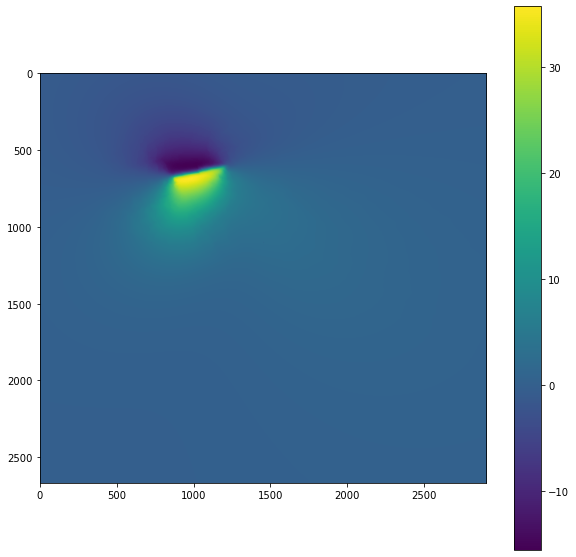

In [6]:
# load in the ungeocoded model
ifgfile=gdal.Open(ungeo_model,gdal.GA_ReadOnly)  
rb = ifgfile.GetRasterBand(1)                         # phase info is in band 2
model = rb.ReadAsArray()                                # read it in as a number array



# load in the ionosphere 
ifgfile=gdal.Open(unw_iono,gdal.GA_ReadOnly)  
rb = ifgfile.GetRasterBand(1)                         # phase info is in band 2
iono = rb.ReadAsArray()                                # read it in as a number array


# plot the ungeocoded model
fig, ax = plt.subplots(figsize=(10,10))        # new figure called "ax1"
im = ax.imshow(model,origin='upper')             # plot incidence with origin at upper left (isce default)
fig.colorbar(im)                               # plot a color bar!
plt.show()

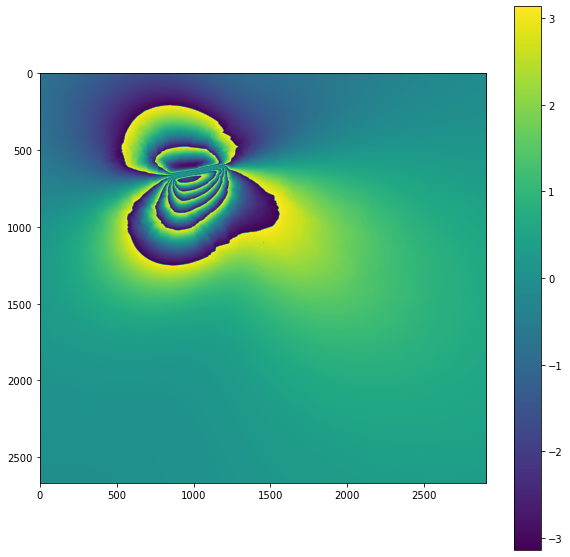

In [7]:
# optional -- plot the wrapped model to double check 
wrap_model = np.multiply(model, 1)

while np.nanmax(wrap_model)>np.pi:
    wrap_model[wrap_model>np.pi]-=2*np.pi

    
while np.nanmin(wrap_model)<-np.pi:
    wrap_model[wrap_model<-np.pi]+=2*np.pi

fig, ax = plt.subplots(figsize=(10,10))        # new figure called "ax1"
im = ax.imshow(wrap_model,origin='upper')             # plot incidence with origin at upper left (isce default)
fig.colorbar(im)                               # plot a color bar!
plt.show()

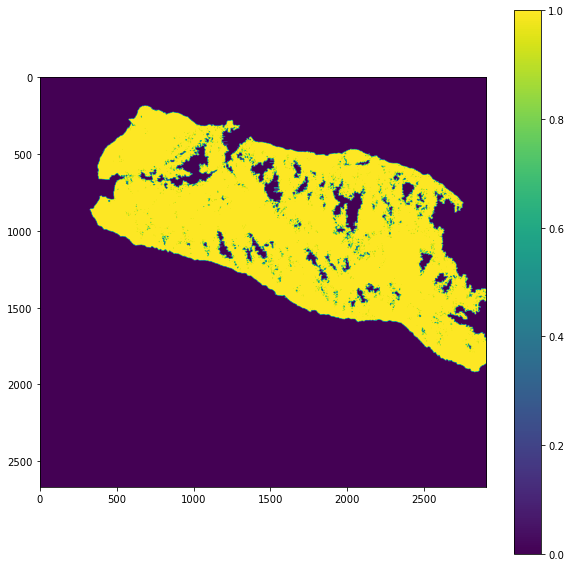

In [8]:
# load in the water mask

water_mask='/home/karlee/earthquakes/alor_2015_JupNot/dsc_half_fringe_digitized/ungeo3/watermk_ungeo.int'

ifgfile=gdal.Open(water_mask,gdal.GA_ReadOnly)  
rb = ifgfile.GetRasterBand(1)                         # phase info is in band 2
msk=rb.ReadAsArray()                                # read it in as a number array


msk[msk!=0]=1


# optionally plot your inputs
fig, ax = plt.subplots(figsize=(10,10))        # new figure called "ax1"
im = ax.imshow(msk,origin='upper')             # plot incidence with origin at upper left (isce default)
fig.colorbar(im)                               # plot a color bar!
plt.show()

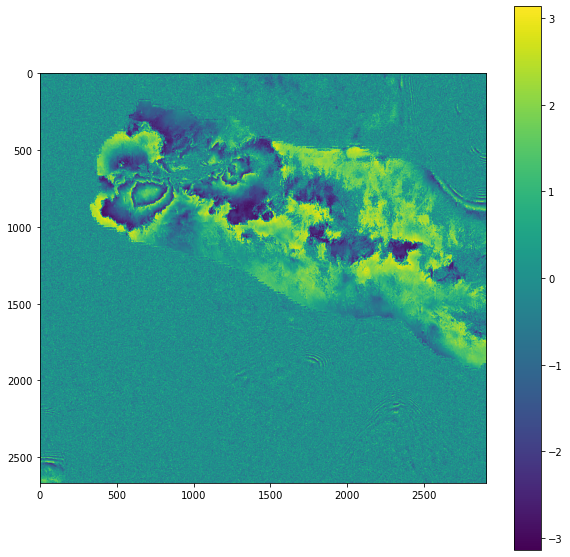

In [9]:
# lets do the subtraction

# this is if we would like to mask
#residual=np.multiply((iphase - model -iono),msk)
#residual= np.multiply(iphase, msk) -np.multiply(model,msk)- np.multiply(iono,msk)

#not masked 
residual= iphase-model -iono


while np.nanmax(residual)>np.pi:
    # print("nanmax = {0:f}".format(np.nanmax(ULOS)))
    residual[residual>np.pi]-=2*np.pi

# and then do the same thing for all values below -pi
    
while np.nanmin(residual)<-np.pi:
    #print("nanmin = {0:f}".format(np.nanmin(ULOS)))
    residual[residual<-np.pi]+=2*np.pi

# optionally plot your inputs
fig, ax = plt.subplots(figsize=(10,10))        # new figure called "ax1"
im = ax.imshow(residual,origin='upper')             # plot incidence with origin at upper left (isce default)
fig.colorbar(im)                               # plot a color bar!
plt.show()

In [24]:
# save the ungeocoded phase as an isce file 

driver = gdal.GetDriverByName('ISCE')
dst_ds = driver.Create(out_isce, xsize=2903, ysize=2668, bands=1, eType=gdal.GDT_Float32)
#look at the .vrt file for the non geocoded files 


# dont need the geocode transform

# set up our spatial reference system (srs)
srs = osr.SpatialReference()
srs.ImportFromEPSG(4326)

# and write that thing out
dst_ds.SetProjection(srs.ExportToWkt())
dst_ds.GetRasterBand(1).WriteArray(residual)

# finish by closing the dataset properly
dst_ds = None

# and now a vrt file
driver = gdal.GetDriverByName('VRT')
dst_ds = driver.Create(out_isce+'.vrt', xsize=2903, ysize=2668, bands=1, eType=gdal.GDT_Float32)


# finish by closing the dataset properly
dst_ds = None

In [25]:
# set up our spatial reference system (srs)
#srs = osr.SpatialReference()
srs.ImportFromEPSG(4326)

# and write that thing out
#dst_ds.SetProjection(srs.ExportToWkt())
#dst_ds.GetRasterBand(1).WriteArray(ULOS)

# finish by closing the dataset properly
#dst_ds = None

# now for the ISCEness
obj = isceobj.createImage()
obj.setFilename(out_isce)

obj.setWidth(2903) #Width is required -this would be the xsize= in los.file.RasterXsize

obj.setDataType('FLOAT')
obj.setInterleavedScheme('BIP') #BIL / BIP / BSQ
obj.setBands(1) # we only have band
obj.setAccessMode('read') #read / Write
obj.setCaster('read','FLOAT') #Mode needed in caster definition
obj.createImage() #Now object behaves like float image


###Use obj here for processing
# other words lets close the image!
obj.finalizeImage() #Close image after use
obj.renderHdr() #Create ISCE XML file if needed

GDAL open (R): final_model.flat.vrt
GDAL close: final_model.flat.vrt
API open (R): final_model.flat
API close:  final_model.flat


In [28]:
# next we need to extract both the phase and the amplitude from the interferogram using imagemath.py 
#!imageMath.py -H

#!imageMath.py -e='abs(a)*exp(J*arg(b))' -o filt_topophase.flat -t f --a=amplitude.flat --b=final_model.flat

!imageMath.py -e='a*exp(J*b)' -o filt_topophase.flat -t F --a=amplitude.flat --b=final_model.flat

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
args:  Namespace(debug=False, dtype='F', equation='a*exp(J*b)', hh=None, noxml=False, out='filt_topophase.flat', scheme='BSQ')
files:  ['--a=amplitude.flat', '--b=final_model.flat']
/home/gareth/pkgs/isce2/applications/imageMath.py:418: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

The next step will be to add the filt_topophase.flat into the isce processing step to rewrap the resdiual that was created